# Analysis of Production Data – State Detection of Cutting Blades
## Dataset: One Year Industrial Component Degradation of a Cutting Blade

*Author: David Geßner* <br>
Originally created as a university project, later refactored and polished.

## 0. Introduction

This project analyses sensor data from an industrial shrink‑wrap packaging machine (OCME Vega) to assess the condition of a cutting
blade over time. The blade cuts film in continuous operation and is subject to mechanical wear.

The goal is to use machine learning to classify operating modes and detect patterns that indicate blade wear or anomalous behaviour. In the long term, such models can enable data‑driven condition monitoring and predictive maintenance.

The workflow in this notebook follows the CRISP‑DM process for data‑driven projects.

## 1. Business understanding (CRISP‑DM Phase 1)

In industrial packaging, cutting blades in machines such as the OCME Vega are used to cut shrink film and are subject to mechanical wear. Progressive wear can affect both product quality and the efficiency of the packaging process.

The high‑level goal of this project is to analyse machine sensor data to detect changes in blade behaviour and the overall system state. This enables data‑driven condition monitoring and, in the long term, predictive maintenance.

Typical ML‑oriented questions include:
- Can different operating modes (e.g. "mode1", "mode2") be reliably classified?
- Did a blade change occur during the recorded period?
- For predictive maintenance: how much useful lifetime remains for a given blade?


## 2. Data understanding (CRISP‑DM Phase 2)

In this phase, the provided dataset is analysed to build a solid understanding of its structure, contents, and key characteristics. The goal is to understand how the time‑series signals behave over time, which sensor channels are available, and what can already be inferred from basic inspection.

Concretely, the following steps are performed:
- Inspecting the folder and file structure
- Reviewing and comparing individual signal segments
- Exploratory visualisation of typical signal trajectories
- Comparing operating modes at the signal level
- Assessing data quality (e.g. completeness, obvious anomalies)

The outcomes of this analysis refine the project objectives and clarify to what extent the data is suitable for machine‑learning tasks such as classification, regression, or anomaly detection.


In [1]:
# Data handling
import pandas as pd

from collections import Counter

# Plotting
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split

# Project modules
from src.helpers import download_dataset, load_all_raw_files
from src.preprocessing import drop_irrelevant_signals_inplace, check_missing_and_duplicates
from src.features import add_degradation_labels, add_mode_labels, add_heuristic_anomaly_labels, add_fft_lag_error_features, build_feature_table
from src.models import standardize_features_with_renaming, run_random_forest_mode_classification, run_ridge_degradation_regression, run_isolation_forest_anomaly_detection
from src.evaluation import evaluate_mode_classifier_folds, evaluate_ridge_regression_folds, evaluate_anomaly_detection_folds


In [2]:
data_dir = download_dataset()

Dataset directory already contains files – no download necessary.
Using data directory: data


In [3]:
# List all subdirectories in data/
subdirs = [d.name for d in data_dir.iterdir() if d.is_dir()]
print("Subdirectories in data/:", subdirs)

# One-year cutting blade dataset directory
oneyear_dir = data_dir / "oneyeardata"

# Count CSV files
data_files = sorted(oneyear_dir.glob("*.csv")) if oneyear_dir.exists() else []
print(f"Number of files in /oneyeardata: {len(data_files)}")

print("Example data files:")
for f in data_files[:5]:
    print("-", f.name)

Subdirectories in data/: ['oneyeardata']
Number of files in /oneyeardata: 519
Example data files:
- 01-04T184148_000_mode1.csv
- 01-04T184424_001_mode1.csv
- 01-04T184835_002_mode1.csv
- 01-04T185047_003_mode1.csv
- 01-04T185257_004_mode1.csv


### 2.1 File structure and format

The time series data is stored in `data/oneyeardata/` as structured `.csv` files.

**File format and structure:**
- Each file contains a time window of approximately 8.2 seconds.
- Sampling rate: 4 ms → 2048 data points per file.
- All files share the same column layout and are fully labelled.
- Filenames follow a consistent pattern, for example:
  - `12-25T124201_508_mode1.csv`
  - `12-28T185909_518_mode2.csv`

From the filename, the following information can be extracted:
- Date and time (e.g. `12-25T124201`)
- Index / running counter (e.g. `508`)
- Operating mode (e.g. `mode1`)

This naming convention allows straightforward extraction of operating modes and timestamps for further analysis. 

In [4]:
# reading all csv files and creating list of dataframes
df_list = load_all_raw_files(data_dir)

<Figure size 800x400 with 0 Axes>

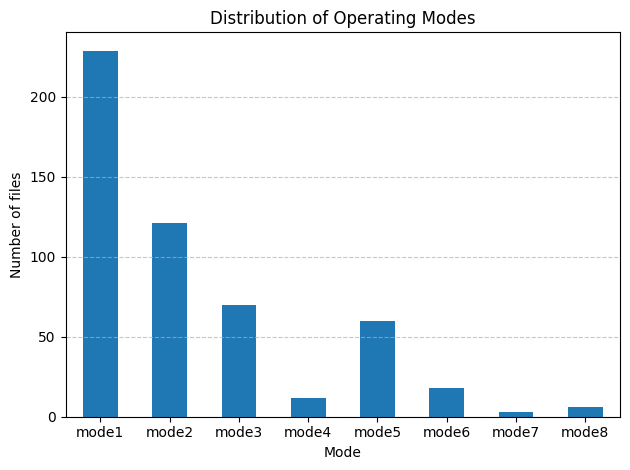

In [5]:
# Distribution of operating modes
# Extract mode from filenames (e.g. "..._mode3.csv" -> "mode3")
modes = [f.name.split("_")[-1].replace(".csv", "") for f in data_files]
mode_counts = Counter(modes)

# Convert to DataFrame for plotting
df_modes = (
    pd.DataFrame.from_dict(mode_counts, orient="index", columns=["count"])
    .sort_index()
)

# Plot
plt.figure(figsize=(8, 4))
df_modes.plot(kind="bar", legend=False)
plt.title("Distribution of Operating Modes")
plt.xlabel("Mode")
plt.ylabel("Number of files")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

**Observations:**
- All eight modes are present in the dataset.
- The distribution is not perfectly balanced – some modes (e.g. `mode1`, `mode2`) occur significantly more often than others (`mode7`, `mode8`).

**Implications for the next steps:**
- For a robust evaluation of the models, the class distribution should be taken into account in the train/test split.
- For very rare modes, it may be helpful to merge them or group them as “other”, depending on the use case.

### Signal exploration – interpretation
Visual inspection of the most relevant sensor signals in an exemplary file.

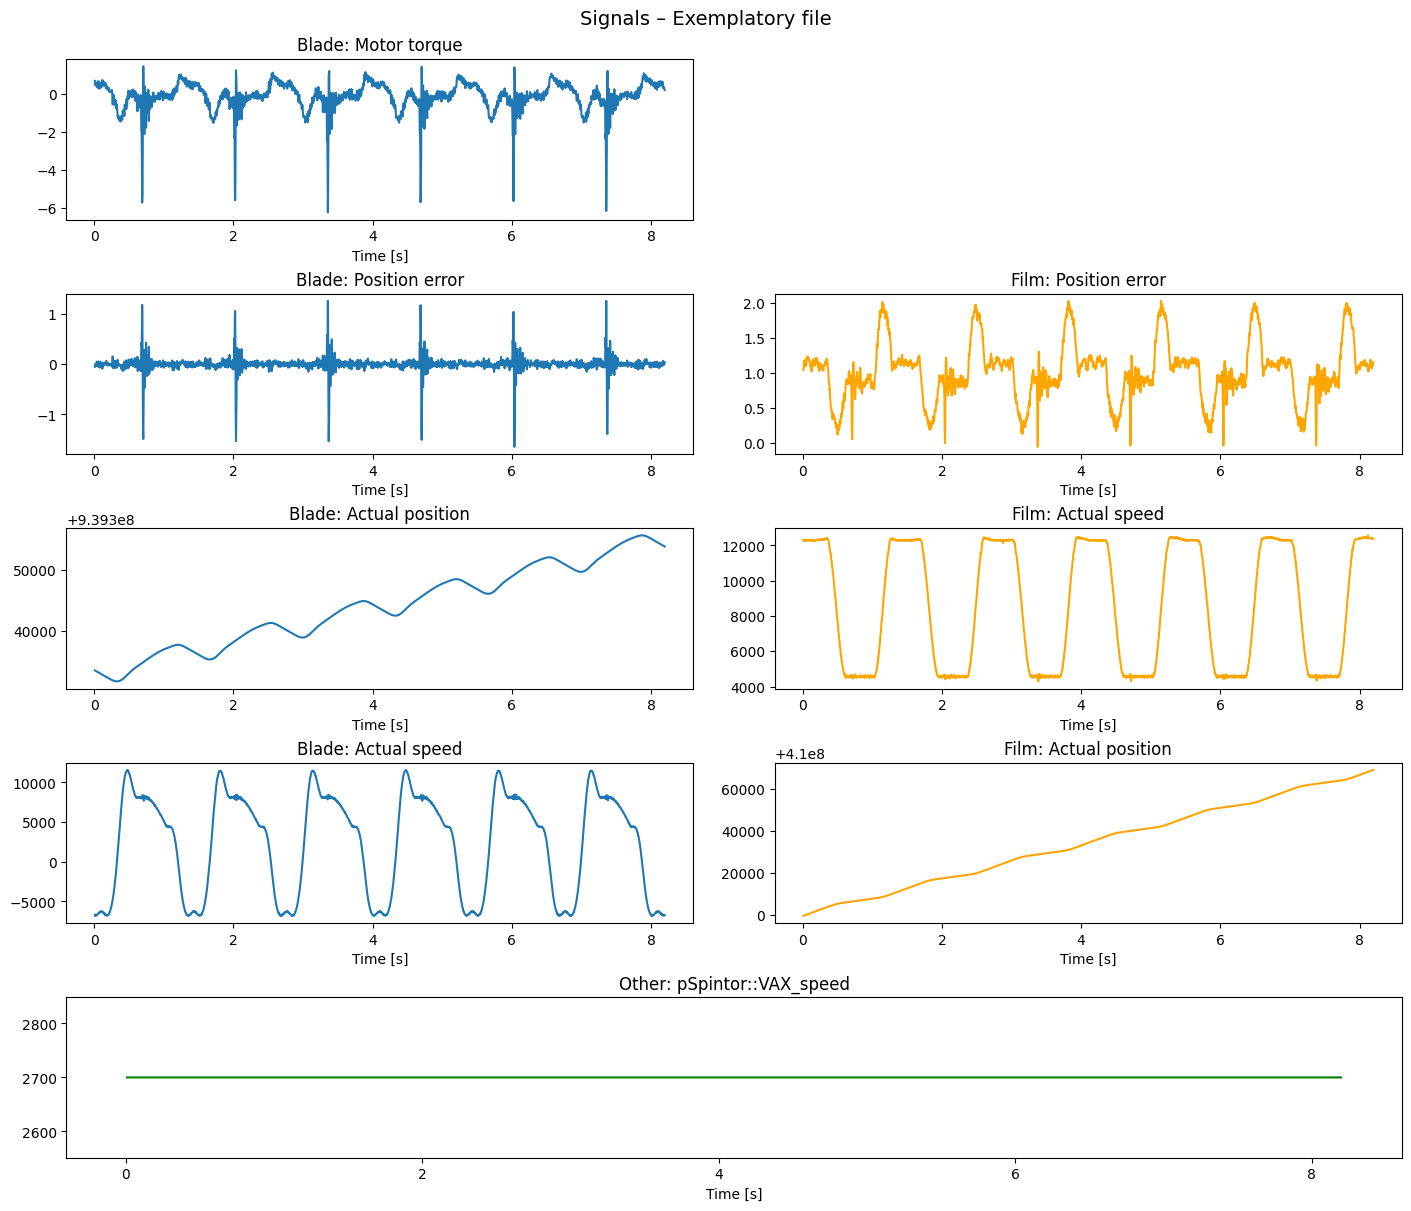

In [6]:
# example file for EDA
exploratory_example_file = df_list[0]

time = "timestamp"

motor_torque = "pCut::Motor_Torque"
knife_lag = "pCut::CTRL_Position_controller::Lag_error"
knife_pos = "pCut::CTRL_Position_controller::Actual_position"
knife_speed = "pCut::CTRL_Position_controller::Actual_speed"

film_pos = "pSvolFilm::CTRL_Position_controller::Actual_position"
film_speed = "pSvolFilm::CTRL_Position_controller::Actual_speed"
film_lag = "pSvolFilm::CTRL_Position_controller::Lag_error"

unknown_signal = "pSpintor::VAX_speed"

# Plot-Setup
fig = plt.figure(constrained_layout=True, figsize=(14, 12))
gs = fig.add_gridspec(nrows=5, ncols=2)

# left column of plot (knife signals)
knife_signals = [motor_torque, knife_lag, knife_pos, knife_speed]
knife_titles = ["Blade: Motor torque", "Blade: Position error", "Blade: Actual position", "Blade: Actual speed"]
for i, col in enumerate(knife_signals):
    ax = fig.add_subplot(gs[i, 0])
    ax.plot(exploratory_example_file[time], exploratory_example_file[col])
    ax.set_title(knife_titles[i], fontsize=12)
    ax.set_xlabel("Time [s]")
    
# right column of plot (film signals)
film_signals = [film_lag, film_speed, film_pos]
film_titles = ["Film: Position error", "Film: Actual speed", "Film: Actual position"]

for i, col in enumerate(film_signals):
    ax = fig.add_subplot(gs[i+1, 1])
    ax.plot(exploratory_example_file[time], exploratory_example_file[col], color="orange")
    ax.set_title(film_titles[i], fontsize=12)
    ax.set_xlabel("Time [s]")

ax = fig.add_subplot(gs[4, :])
ax.plot(exploratory_example_file[time], exploratory_example_file[unknown_signal], color="green")
ax.set_title(f"Other: {unknown_signal}", fontsize=12)
ax.set_xlabel("Time [s]")

plt.suptitle("Signals – Exemplatory file", fontsize=14)
plt.show()

After visual inspection of the most relevant sensor signals in an examplatory file, the following observations and implications arise:

#### Knife (pCut)
- **Motor torque**: Shows cyclic fluctuations with characteristic drops, indicating periodically recurring loads during the cutting process.
- **Position error**: Remains mostly close to zero but exhibits occasional peaks, which may indicate short-term control deviations or disturbances.
- **Actual position**: Evolves continuously with a periodic structure and is well suited for detecting motion cycles.
- **Actual speed**: Clear cyclic signature with regular acceleration and deceleration phases in both directions. Highly suitable for mode classification and segmentation. The pronounced variability of the speed values suggests regular motion patterns within a production cycle.

#### Film (pSvolFilm)
- **Position error**: Shows dynamic behaviour but differs clearly from the knife control, indicating a likely independent control loop from the knife.
- **Actual speed**: Rectangular profiles with clear transitions, very useful for identifying operating phases.
- **Actual position**: Monotonically increasing course, typical for continuous transport motion and potentially helpful for segmentation.

#### Other signals
- **pSpintor::VAX_speed**: Nearly constant without relevant dynamics and therefore likely not useful for the subsequent analyses.
       --> Removed from the DataFrames

---

#### Conclusions for further analysis
- The knife signals form the basis for differentiated condition monitoring and enable the identification of potential wear or degradation effects.
- A combination of position, speed, and error values provides a robust foundation for feature engineering in the context of classification, regression, and anomaly detection.
- The differing characteristics of knife and film signals allow a more fine‑grained view of machine components and sub‑processes.
- Signal quality is sufficiently high to allow further processing without additional smoothing, since all relevant structures and variations are clearly visible.
- The raw dataset does not contain physical units. As these are irrelevant for the applied algorithms, all signals are treated as unitless within this analysis.


In [7]:
# removing unneccessary signal column
drop_irrelevant_signals_inplace(df_list)

### Statistical analysis of sensor signals

For a better quantitative assessment of the sensor behaviour, one exemplary file was analysed statistically. For each signal, minimum, maximum, mean, and standard deviation were computed and summarised in a compact table.

In [8]:
signal_cols = exploratory_example_file.columns[1:]

#calculate statistics
summary_stats = exploratory_example_file[signal_cols].describe().T[["min", "max", "mean", "std"]]
summary_stats.columns = ["Minimum", "Maximum", "Mean", "STD"]
summary_stats = summary_stats.map(lambda x: f"{x:.3f}")
summary_stats.index = [
    "Blade: motor torque",
    "Blade: position error",
    "Blade: current position",
    "Blade: current speed",
    "Film: current position",
    "Film: current speed",
    "Film: position error"
]

display(summary_stats)

,Minimum,Maximum,Mean,STD
Blade: motor torque,-6.219,1.435,-0.137,0.753
Blade: position error,-1.646,1.265,-0.000,0.163
Blade: current position,939331667.000,939355671.000,939343938.693,6636.178
Blade: current speed,-6814.957,11573.409,2483.787,6318.147
Film: current position,409999463.000,410069284.000,410034553.304,19893.287
Film: current speed,4293.554,12568.588,8527.520,3490.534
Film: position error,-0.055,2.034,1.016,0.411


**Observations**

- The **motor torque** signal of the knife has a mean close to 0 and a relatively high standard deviation, indicating oscillatory behaviour and cyclic loading during the cutting process.
- The **current position values** of knife and film are in the order of 10⁸ to 10⁹, which strongly suggests encoder counts; this scale is not suitable for machine learning models and should be adjusted via appropriate normalisation or scaling.
- The **current speed** signals show a large range around a well-defined zero, reflecting high dynamic variation between forward and backward motion.
- The **lag error signals** (position errors) mostly lie within ±1 and show occasional peaks, pointing to short-term control deviations or mechanical disturbances.

**Implications for modelling**

- Applying scaling to all signals is essential to ensure numerical stability and to avoid bias in the learning algorithms.
- The computed statistics support early detection of unusual value ranges or potential anomalies.
- The preceding exploration enables a targeted selection of informative features for subsequent steps such as classification, anomaly detection, or remaining useful life (RUL) estimation.


### Analysis of data quality

In a dedicated step, the data quality of all loaded files is checked by counting both the numbers of missing values (NaN) and duplicate rows. Files that intentionally contain NaN values due to invalid time stamps (listed in a whitelist) are excluded from this check.

For every remaining file, the procedur:
- counts how many entries contain NaN values,
- counts how many duplicate rows exist.

If any issues are detected, the file name together with the respective count of NaNs and duplicates is printed.


In [9]:
probleme_gefunden = False

# Whitelist for files with intentionally set NaN values (due to faulty files; see date in first code cell of chapter 3)
whitelist_files = {
    "02-30T115339_167_model1.csv",
    "02-30T120535_168_model1.csv", 
    "02-30T111929_165_model1.csv",
    "02-30T113211_166_model1.csv",
    "02-30T122614_169_model1.csv",
    "02-30T104928_164_model1.csv"
}

check_missing_and_duplicates(df_list, data_files, whitelist_files)


No missing values or duplicate rows were found in any file.


### Refined Objectives Based on Exploratory Data Analysis (EDA)

The initial goal of this project was to model various aspects of the machine's condition—specifically, operating mode identification, anomaly detection, and blade wear estimation.

The exploratory data analysis has yielded the following key insights:

* **Cyclical Patterns:** The time-series data exhibit strong cyclical behavior, particularly within the blade velocity signals.
* **Signal Characteristics:** Specific signals (e.g., position lag/following error and motor torque) show characteristic patterns and outliers suitable for anomaly detection.
* **Temporal Proxy:** The temporal encoding in the filenames allows for the derivation of a heuristic state variable, which serves as a proxy for blade wear (detailed in Chapter 3; CRISP-DM Phase 3).

Based on these findings, the project focuses on three technically compatible objectives:

1. **Classification**: Automatic identification of the machine’s operating mode using characteristic patterns in velocity, position and control deviation.
2. **Anomaly Detection**: Detection of unusual signal profiles (e.g., significant deviations in lag error or torque) to identify potential malfunctions or the onset of wear at an early stage.
3. **Regression-based Degradation Estimation**: A heuristic approximation of the blade's wear state based on the recording timestamp and signal dynamics (e.g., torque profile, cyclical behavior).

The subsequent steps will specifically address these refined objectives.


## 3. Data Preparation (CRISP-DM Phase 3)

In this phase, the time-series data is systematically processed for use in machine learning models. Building on the results of the exploratory analysis, new features are generated, target variables are defined, and the data is structured to ensure suitability for the modeling process.

### Deriving Degradation Labels from Filenames – Handling Invalid Timestamps

To generate a continuous degradation label, the date and time are extracted from the filename and converted into a normalized time value (on a scale from 0 to 1).

#### Handling Invalid Timestamps

Some filenames contain invalid calendar days (e.g., February 30th), which cause errors during date conversion. This issue is assumed to originate from a faulty timestamp generation process within the original data pipeline.

**Approach:**
- We assume **2024** as the reference year (a leap year, making it more robust for date parsing).
- Invalid dates are **skipped**, and the corresponding files are assigned a `NaN` label.
- This is addressed later in the modeling process (e.g., via removal or imputation).

This decision is justified as only a very small number of files are affected (n=6; approx. 1%, as shown in the following code cell), and the date information is used solely for the generation of artificial labels.

In [10]:
df_list = add_degradation_labels(df_list)

Error processing file 02-30T115339_167_mode1.csv: day is out of range for month - Filling with NaN
Error processing file 02-30T120535_168_mode1.csv: day is out of range for month - Filling with NaN
Error processing file 02-30T111929_165_mode1.csv: day is out of range for month - Filling with NaN
Error processing file 02-30T113211_166_mode1.csv: day is out of range for month - Filling with NaN
Error processing file 02-30T122614_169_mode1.csv: day is out of range for month - Filling with NaN
Error processing file 02-30T104928_164_mode1.csv: day is out of range for month - Filling with NaN


### Mode label from Filename

To prepare for classification, the operating mode (e.g. `mode1`, `mode2`, …) encoded in the file name is extracted and inserted as a new `mode` column into each DataFrame. This label later serves as the target variable for the classification task.


In [11]:
#extract and add mode labels for each file
df_list = add_mode_labels(df_list)

### Heuristic anomaly label generation

Since the dataset does not contain explicit anomaly labels, this step heuristically creates a pseudo‑supervised anomaly label.
The signal `pCut::CTRL_Position_controller::Lag_error` is used for this, as it is considered particularly error‑prone and sensitive to mechanical deviations.

The procedure is as follows:

1. For each file, the mean and standard deviation of the `Lag_error` signal are computed.
2. A threshold is then defined: Anomaly = |Lag_error| > (mean + 1.5 × standard deviation).
3. Each timestamp is assigned an anomaly label (`0`/`1`) based on this rule.
4. Finally, a file‑level label `file_anomaly` is set if more than 5% of the timestamps in that file are classified as anomalous.



In [12]:
# heuristic anomaly labeling based on Lag_error
df_list = add_heuristic_anomaly_labels(
    df_list,
    lag_error_col="pCut::CTRL_Position_controller::Lag_error",
    std_factor=1.5,
    anomaly_ratio_threshold_per_file=0.05,
)

# quick sanity check: how many files are marked as anomalous?
anomalous_rated_files = sum(df["file_anomaly"].iloc[0] == 1 for df in df_list)
print(f'There are {anomalous_rated_files} anomalous rated files out of {len(df_list)} total files. \n'
      f'This is {anomalous_rated_files/len(df_list)*100:.2f}% of all recordings.')

There are 16 anomalous rated files out of 519 total files. 
This is 3.08% of all recordings.


### Frequency features via Fourier transform

Based on the `Lag_Error` signal, a Fast Fourier Transform (FFT) is computed and the following features are extracted:

- Maximum frequency amplitude
- Frequency with maximum energy
- Total spectral energy

These features serve as additional input variables for later models for anomaly detection and degradation estimation.

In [13]:
df_list = add_fft_lag_error_features(df_list)

### Statistical features per sensor signal

To obtain a more robust representation of the machine state, additional sensor
signals beyond the knife lag error are taken into account.

For each relevant signal, the following features are computed per file:

- Mean (`mean`)
- Standard deviation (`std`)
- Minimum (`min`)
- Maximum (`max`)
- Fraction of strong deviations (`outlier_ratio`), defined as |z| > 2

The resulting feature matrix is used as input for classification, regression,
and anomaly detection models.

In [14]:
feature_df = build_feature_table(df_list)
display(feature_df.head())

,K_PF_mean,K_PF_std,K_PF_min,K_PF_max,K_PF_outl,K_SPD_mean,K_SPD_std,K_SPD_min,K_SPD_max,K_SPD_outl,...,F_SPD_max,F_SPD_outl,F_POS_mean,F_POS_std,F_POS_min,F_POS_max,F_POS_outl,mode,degradation,file_anomaly
0,-0.000299,0.096993,-1.396096,0.805162,0.020996,1531.201006,3034.897363,-4216.003418,6667.327637,0.00000,...,4102.282227,0.000000,5.508819e+06,7022.159660,5496291,5520568,0.0,mode1,0.010929,0
1,-0.000040,0.093005,-1.238697,0.915148,0.021484,1293.845632,3485.313242,-4895.782227,7673.263184,0.00000,...,4718.883301,0.000000,5.312998e+06,7972.001288,5298555,5325625,0.0,mode1,0.010929,0
2,0.000141,0.098619,-1.585237,0.991394,0.020996,1306.567685,3349.662564,-4895.782227,7680.129883,0.00000,...,4716.366211,0.000000,6.587871e+06,7847.090184,6575384,6601954,0.0,mode1,0.010929,0
3,-0.000002,0.078300,-1.302894,0.772504,0.017090,644.450983,2935.786403,-4888.916016,7244.109863,0.03125,...,4708.815918,0.014648,6.155114e+06,6766.164382,6142668,6164963,0.0,mode1,0.010929,0
4,0.000076,0.094756,-1.332262,0.963179,0.020508,1367.641579,3508.503226,-4895.782227,7693.862793,0.00000,...,4728.950195,0.000000,6.975461e+06,8159.176330,6961539,6989082,0.0,mode1,0.010929,0


## Standardization of numerical features (EDA Display Only)

The feature table is standardized here **solely for display and exploratory purposes**.

> **Note on data leakage prevention:** The model functions do **not** use
> `feature_scaled_df` as input. Instead, each model pipeline (`Pipeline(StandardScaler → model)`)
> performs standardization **internally per fold**, fitting the scaler exclusively
> on the training split. This prevents data leakage from the validation set
> into the scaler's `fit()` call.

The target variables (`mode`, `degradation`, `file_anomaly`) remain unchanged.


In [15]:
label_cols = ["mode", "degradation", "file_anomaly"]

# only for EDA purposes and for diplaying the df
feature_scaled_df, scaler = standardize_features_with_renaming(
    feature_df=feature_df,
    label_cols=label_cols
)

display(feature_scaled_df.head())

,K_PF_mean,K_PF_std,K_PF_min,K_PF_max,K_PF_outl,K_SPD_mean,K_SPD_std,K_SPD_min,K_SPD_max,K_SPD_outl,...,F_SPD_max,F_SPD_outl,F_POS_mean,F_POS_std,F_POS_min,F_POS_max,F_POS_outl,mode,degradation,file_anomaly
0,-0.535271,-0.699599,-0.293330,-0.621968,-0.658133,-0.615756,-1.084033,0.913072,-0.814031,-0.154047,...,-0.969583,-0.108546,-0.528548,-1.023371,-0.528516,-0.528582,-0.043937,mode1,0.010929,0
1,0.032320,-0.835091,0.455074,-0.318989,-0.571175,-0.968277,-0.773021,0.497613,-0.429575,-0.154047,...,-0.815816,-0.108546,-0.529270,-0.852918,-0.529245,-0.529301,-0.043937,mode1,0.010929,0
2,0.429094,-0.644350,-1.192659,-0.108951,-0.658133,-0.949383,-0.866688,0.497613,-0.426950,-0.154047,...,-0.816444,-0.108546,-0.524568,-0.875334,-0.524536,-0.524594,-0.043937,mode1,0.010929,0
3,0.114948,-1.334685,0.149831,-0.711932,-1.353798,-1.932761,-1.152469,0.501809,-0.593592,4.751834,...,-0.818327,2.523958,-0.526164,-1.069310,-0.526132,-0.526206,-0.043937,mode1,0.010929,0
4,0.286441,-0.775576,0.010192,-0.186677,-0.745092,-0.858675,-0.757008,0.497613,-0.421702,-0.154047,...,-0.813305,-0.108546,-0.523139,-0.819329,-0.523112,-0.523166,-0.043937,mode1,0.010929,0


### Train/Test Split

To prepare the data for model training, the dataset is split into training and
test sets.
A stratified split is used to ensure that the distribution of the target
class `mode` is similar in both subsets.

In [16]:
# define feature matrix and target variable (for classification)
X = feature_scaled_df.drop(columns=["mode", "degradation", "file_anomaly"])
y = feature_scaled_df["mode"]  # target: mode classification

# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# reset indices after splitting
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# overview of data split
print("DATA SPLIT OVERVIEW")
print("=" * 40)
print(f"X (Features):        {X.shape}")
print(f"y (Labels):          {y.shape}")
print("-" * 40)
print(f"X_train:             {X_train.shape}")
print(f"X_test:              {X_test.shape}")
print(f"y_train:             {y_train.shape}")
print(f"y_test:              {y_test.shape}")
print("-" * 40)
print(f"Train/Test Ratio:    {len(y_train)}/{len(y_test)} ({len(y_train)/len(y)*100:.0f}%/{len(y_test)/len(y)*100:.0f}%)")

DATA SPLIT OVERVIEW
X (Features):        (519, 35)
y (Labels):          (519,)
----------------------------------------
X_train:             (415, 35)
X_test:              (104, 35)
y_train:             (415,)
y_test:              (104,)
----------------------------------------
Train/Test Ratio:    415/104 (80%/20%)


### Validation strategy – K-fold cross-validation

To reliably assess the generalization performance of the models, K-fold
cross-validation is applied.

The training data is split into K equally sized folds. In each run, one fold
is used for validation while the remaining folds are used for training. The
performance of the model is estimated by averaging the performance estimates of
the K models trained on different folds.

This reduces the variance of the performance estimate and is a well-established
approach, especially for smaller datasets.


In [17]:
Counter(y_train)

Counter({'mode1': 183,
         'mode2': 97,
         'mode3': 56,
         'mode5': 48,
         'mode6': 14,
         'mode4': 10,
         'mode8': 5,
         'mode7': 2})

Since some operating modes in the dataset are very rare (e.g. `mode7` with only
a few instances), the number of folds is reduced to `n_splits = 2`.

This keeps the stratified split valid and prevents errors that would occur if
certain classes were completely missing in individual folds.

In [18]:
# configuration
k_folds = 2
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# print fold distribution
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    print(f"Fold {fold+1}: Train={len(train_idx)} | Validation={len(val_idx)}")

Fold 1: Train=207 | Validation=208
Fold 2: Train=208 | Validation=207


## 4. Model building (CRISP-DM Phase 4)

In this section, three different ML models are developed, each targeting one
central objective of the project:

1. **Classification of the machine operating mode:** Predicting the current
   mode (e.g. `mode1`, `mode2`, …) based on characteristic feature patterns.
2. **Regression-based degradation estimation:** Estimating relative blade wear
   (label `degradation`) as a continuous target variable.
3. **Anomaly detection:** Identifying potentially faulty file sequences based
   on aggregated features (label `file_anomaly`).

The three tasks are modeled, evaluated, and documented independently of each
other.


### 4.1 Classification – machine operating mode

**Objective:** Automatic prediction of the machine operating mode (`mode`)
based on aggregated signal features. This enables later state identification
even without explicit mode annotations.

**Model:** `RandomForestClassifier` (robust, relatively interpretable, low
scaling requirements).

**Target variable:** `mode`
**Input:** All numerical features from `feature_scaled_df`
**Validation:** 2-fold stratified K-Fold


In [19]:
# Features and target — use raw (unscaled) feature_df
X_cls = feature_df.drop(columns=["mode", "degradation", "file_anomaly"])
y_cls = feature_df["mode"]

predictions_classification = run_random_forest_mode_classification(
    X=X_cls,
    y=y_cls,
    cv=cv,
)

Model: Pipeline(StandardScaler → RandomForestClassifier)
Parameters: n_estimators=100, random_state=42

Fold 1
  Training on 259 samples, Validation on 260 samples
  model training done
  predictions generated

Fold 2
  Training on 260 samples, Validation on 259 samples
  model training done
  predictions generated

Finished modeling — 2 trained folds


### 5.2 Regression model – degradation estimation

**Objective:**
Predict the relative wear state of the blade based on aggregated signal
features. The label `degradation` represents an artificially generated,
monotonically increasing index between 0 (new blade) and 1 (end-of-life).

**Model:**
A `Ridge` regressor (linear regression with L2 regularization) is used because:
- the target is continuous
- a roughly linear relationship between signals and wear is assumed
- the model is robust to correlated features

**Target variable:** `degradation`
**Input:** All numerical features
**Validation:** 2-fold K-Fold cross-validation


In [20]:
# Use raw (unscaled) feature_df
y_reg = feature_df["degradation"]
X_reg = feature_df.drop(columns=["mode", "file_anomaly", "degradation"])

# Remove rows with NaN labels
valid_rows = y_reg.notna()
X_reg_clean = X_reg[valid_rows].copy()
y_reg_clean = y_reg[valid_rows].copy()

# Bins for stratified CV split
y_reg_cat = pd.qcut(y_reg_clean, q=2, labels=False, duplicates="drop")

# CV config
k_folds = 2
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_reg_clean, y_reg_cat)):
    print(f"Fold {fold+1}  Train={len(train_idx)}  Validation={len(val_idx)}")

predictions_ridge = run_ridge_degradation_regression(
    X=X_reg_clean,
    y=y_reg_clean,
    y_cat=y_reg_cat,
    cv=cv,
)

Fold 1  Train=256  Validation=257
Fold 2  Train=257  Validation=256
model initialised: Pipeline(StandardScaler → Ridge Regression)
parameter standard: alpha=1.0

Fold 1
  Training on 256 Samples, Validation on 257 Samples
  model training done
  predictions generated

Fold 2
  Training on 257 Samples, Validation on 256 Samples
  model training done
  predictions generated

Finished modeling — 2 trained folds


### 5.3 Anomaly detection – detection of abnormal operation

**Objective:**
Automatic identification of unusual or potentially faulty machine states based
on aggregated signal features.

The label `file_anomaly` indicates whether a file shows anomalous behaviour
(heuristically generated via a threshold-based approach, see feature
engineering).

**Model:**
An `IsolationForest` is used as a classical unsupervised anomaly detector,
because:

- no explicitly labelled anomaly examples are available
- the method is robust to outliers and scale differences
- detection is based purely on statistical deviations in the feature
  distributions

**Target variable:** `file_anomaly` (0: normal, 1: anomalous) </br>
**Input:** All scaled numerical features </br>
**Validation:** K-fold cross-validation, evaluated via precision, recall, and
F1-score with respect to the `file_anomaly` label


In [21]:
# Use raw (unscaled) feature_df
X_anom = feature_df.drop(columns=["mode", "degradation", "file_anomaly"])
y_anom = feature_df["file_anomaly"]

k_folds = 2
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

predictions_anomaly = run_isolation_forest_anomaly_detection(
    X=X_anom,
    y=y_anom,
    cv=cv,
)

model initialised: Pipeline(StandardScaler → Isolation Forest)
parameter: contamination=auto, random_state=42

Fold 1
  Training on 259 Samples, Validation auf 260 Samples
  model training done
  predictions generated

Fold 2
  Training on 260 Samples, Validation auf 259 Samples
  model training done
  predictions generated

Finished modeling — 2 trained folds


## 5.Evaluation (CRISP-DM Phase 5)

### 5.1 Evaluation for mode classifier

FULL MODEL EVALUATION for Mode Classifier

FOLD 1
------------------------------
Accuracy:  0.9538
Precision: 0.9558
Recall:    0.9538
F1-Score:  0.9532

FOLD 2
------------------------------
Accuracy:  0.9768
Precision: 0.9774
Recall:    0.9768
F1-Score:  0.9767

RESULTS (AVERAGE OVER ALL FOLDS)
Accuracy:  0.9653 ± 0.0115
Precision: 0.9666 ± 0.0108
Recall:    0.9653 ± 0.0115
F1-Score:  0.9650 ± 0.0117

CONFUSION MATRIX (AVERAGE)


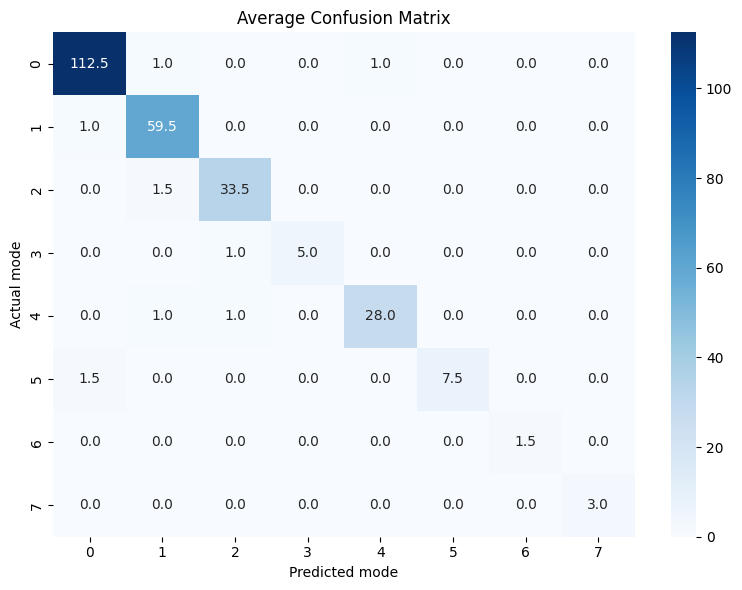


SUMMARY
Number of folds: 2
Best F1-score:   0.9767
Worst F1-score:  0.9532
Stability (std): F1-score ± 0.0117

Stable results across all folds!


In [22]:
evaluate_mode_classifier_folds(predictions_classification)


### 6.2 Evaluation of regression model - degradation

REGRESSION EVALUATION

FOLD 1
------------------------------
MAE:   0.1080
MSE:   0.0187
RMSE:  0.1366
R²:    0.7853
MAPE:  143.17%
Residuals Range: [-0.4421, 0.3798]

FOLD 2
------------------------------
MAE:   0.1072
MSE:   0.0183
RMSE:  0.1354
R²:    0.7931
MAPE:  79.32%
Residuals Range: [-0.3257, 0.4452]

RESULTS (AVERAGE OVER ALL FOLDS)
MAE:   0.1076 ± 0.0004
MSE:   0.0185 ± 0.0002
RMSE:  0.1360 ± 0.0006
R²:    0.7892 ± 0.0039
MAPE:  111.25% ± 31.92%

RESIDUALS-ANALYSIS
Mean:   0.0001
Std:    0.1360
Min:    -0.4421
Max:    0.4452
Median: -0.0049


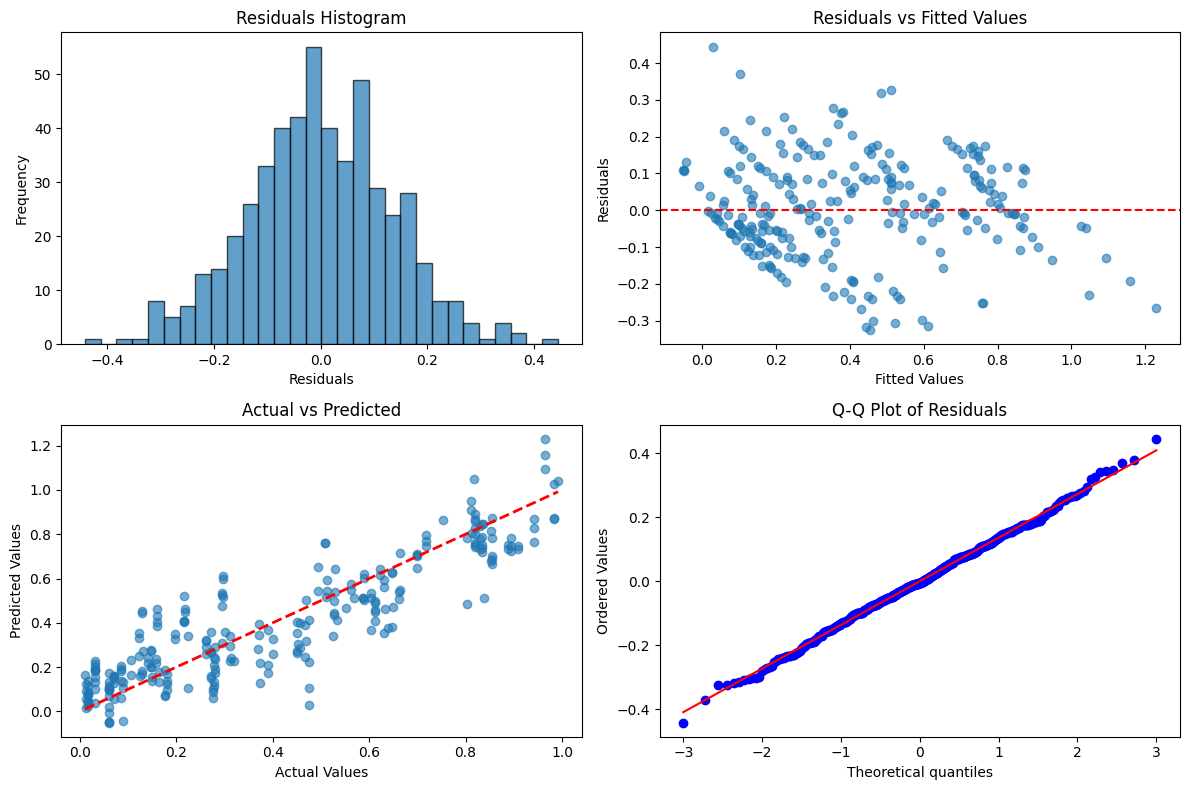


MODEL PERFORMANCE RATING
R² performance: Good (0.7892)
RMSE/MAE ratio: 1.26
 >> Normal error distribution

SUMMARY
Number of folds: 2
Best R²:         0.7931
Worst R²:        0.7853
Stability (std): R² ± 0.0039

Very stable results across all folds!


In [23]:
evaluate_ridge_regression_folds(predictions_ridge)

### 6.3 Evaluation of anomaly detection 

In [24]:
evaluate_anomaly_detection_folds(
    predictions_anomaly=predictions_anomaly,
    X_anom=X_anom,
    y_anom=y_anom,
    cv=cv,
)

ANOMALY DETECTION EVALUATION

FOLD 1
------------------------------
Accuracy:    0.8423
Precision:   0.1333
Recall:      0.7500
F1-Score:    0.2264
Specificity: 0.8452
Confusion Matrix:
  TN: 213  FP:  39
  FN:   2  TP:   6
Detected Anomalies: 17.3% (True: 3.1%)

FOLD 2
------------------------------
Accuracy:    0.8919
Precision:   0.1875
Recall:      0.7500
F1-Score:    0.3000
Specificity: 0.8964
Confusion Matrix:
  TN: 225  FP:  26
  FN:   2  TP:   6
Detected Anomalies: 12.4% (True: 3.1%)

RESULTS (AVERAGE OVER ALL FOLDS)
Accuracy:    0.8671 ± 0.0248
Precision:   0.1604 ± 0.0271
Recall:      0.7500 ± 0.0000
F1-Score:    0.2632 ± 0.0368
Specificity: 0.8708 ± 0.0256

CONFUSION MATRIX ANALYSIS
Aggregated Confusion Matrix:
  TN: 438  FP:  65
  FN:   4  TP:  12

Total Samples: 519
True Negatives Rate:  84.4%
False Positives Rate: 12.5%
False Negatives Rate: 0.8%
True Positives Rate:  2.3%

MODELL-PERFORMANCE RATING
F1-score performance: Bad (0.2632)
Precision-Recall balance: 0.5896
  >> 

## 6. Deployment (CRISP-DM Phase 6)

In this project, an in‑depth analysis of an industrial production dataset was carried out
with the goal of assessing the condition of a cutting blade in a shrink‑film packaging
machine. The workflow followed the CRISP‑DM process model and comprised three central
machine‑learning tasks: classification of operating modes, regression‑based estimation
of blade degradation, and anomaly detection.

### Summary of key findings

The analysis shows that machine data are in principle well suited to derive data‑driven
insights into the machine's condition.

- **Mode classification**: The trained Random Forest model achieved an average accuracy
  of about 97 % across all folds (0.9650 ± 0.0012). This demonstrates that the eight
  operating modes can be reliably distinguished from the engineered statistical and
  signal‑based features alone.

- **Degradation estimation**: The Ridge regression model for predicting the heuristically
  generated degradation label (0 to 1) achieved an R² of around 0.79 (0.7931 ± 0.0039).
  This is a strong result given that the label is derived solely from the timestamp and
  therefore assumes a simplified, approximately linear wear process. The model can explain
  a substantial portion of the variance in the degradation label based only on signal
  characteristics, strongly suggesting that actual wear behaviour is reflected in the
  sensor signals (e.g. motor torque or position error).

- **Anomaly detection**: The Isolation Forest, used as an unsupervised model, showed
  comparatively weak performance with an average F1‑score of about 0.26
  (0.2632 ± 0.0037), while reaching a relatively high specificity of roughly 0.87
  (0.8708 ± 0.0256). This means that normal operating states are usually recognised
  correctly, but the model struggles to accurately identify the few cases labelled as
  anomalous. A likely reason is the heuristic nature of the anomaly labels, which may
  not clearly separate subtle deviations from normal process variability.

### Challenges and limitations

The analysis is subject to several limitations. The labels for degradation and anomalies
are heuristically generated and do not represent true ground‑truth data. A linear
degradation model is a strong simplification. In reality, wear is likely to progress
non‑linearly. Likewise, the anomaly definition is based on statistical assumptions that
may not correspond directly to real machine faults. Strong class imbalance in both
operating modes and anomalies further complicates training and evaluation, and partially
explains the modest detection quality of the anomaly detector.

### Application potential and outlook

Despite these limitations, the results demonstrate considerable potential for practical
deployment in production environments:

- **Condition monitoring**: The classification model can be used to monitor and log the
  machine's operating state over time, reducing reliance on manual annotations and
  enabling basic automated condition tracking.

- **Predictive maintenance**: The regression model forms a solid foundation for Remaining
  Useful Life (RUL) prediction. With access to real wear measurements (e.g. blade
  sharpness or actual blade replacement events), it could be extended into a
  high‑precision predictive‑maintenance model.

- **Early‑warning system**: Although the Isolation Forest currently shows limited
  detection quality, it could serve as a first‑stage early‑warning mechanism. In
  combination with domain‑knowledge‑based rules and improved labels, it may help
  highlight unusual patterns that maintenance personnel should investigate more closely.

Future work should focus on replacing the heuristic labels with real process and
maintenance data. In addition, advanced deep‑learning methods such as LSTMs or 1D‑CNNs
operating directly on the raw time‑series may eliminate the need for manual feature
extraction and offer further improvements in model performance.

Overall, this project demonstrates that a structured, CRISP‑DM‑guided machine‑learning
workflow — even when applied to heuristically labelled data — can yield meaningful,
interpretable models that provide a practical starting point for data‑driven condition
monitoring and predictive maintenance in industrial settings.
